# Hello Variational Autoencoder on FashionMNIST dataset

In [1]:
# Prerequisites
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks, losses, optimizers, metrics
import tensorflow.keras.backend as K

print("Python Version: ", sys.version)
print("TensorFlow Version: ", tf.__version__)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
TensorFlow Version:  2.19.0


### Get FashionMNIST Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

Preprocess Data

In [4]:
def data_preprocess(images):
    # Normalize the images to [0, 1] and convert to float32
    images = images.astype('float32') / 255.0
    # Pad from 28x28 to 32x32
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0.0)
    # Add channel Dimension
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    return images

In [5]:
x_train = data_preprocess(x_train)
x_test = data_preprocess(x_test)

In [6]:
# Helper function to display images
def display_images(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Display n images from array
    """
    # Check that images are scaled to [0, 1] to be compatible with plt.imshow
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    plt.show()

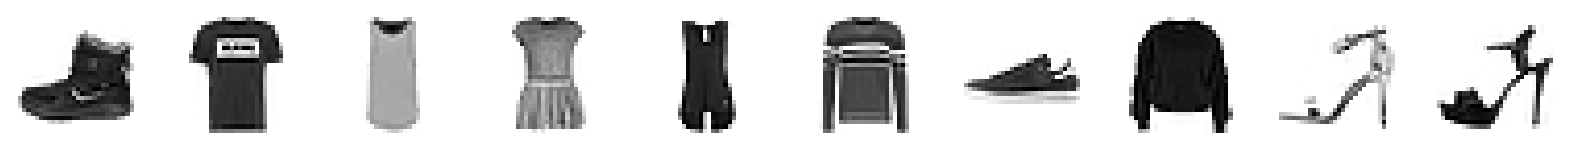

In [7]:
display_images(x_train)


### Build the Encoder

Create a custom Sampling layer

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
EMBEDDING_DIM = 2  # Dimension of the embedding space

# Define the Encoder model
enc_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(enc_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_b4_flattening = K.int_shape(x)[1:]  # Needed for the decoder

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(enc_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

### Build the Decoder

In [10]:
# Define the decoder model
dec_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_b4_flattening))(dec_input)
x = layers.Reshape(shape_b4_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
dec_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(dec_input, dec_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Variational Autoencoder Class

In [11]:
BETA = 500  # Weight for the KL divergence term

# Define the VAE model
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model """
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Run step during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Run step during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1)
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Instantiate the VAE

In [12]:
vae = VAE(encoder, decoder)

### Train the Variational Autoencoder

In [14]:
# Compile
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [15]:
# Train
vae.fit(x_train, epochs=5, batch_size=100, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - kl_loss: 3.5888 - reconstruction_loss: 199.0546 - total_loss: 202.6433 - val_kl_loss: 4.8394 - val_loss: 144.0364 - val_reconstruction_loss: 139.1969
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - kl_loss: 4.8575 - reconstruction_loss: 132.4762 - total_loss: 137.3337 - val_kl_loss: 4.8495 - val_loss: 139.0051 - val_reconstruction_loss: 134.1556
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - kl_loss: 4.9008 - reconstruction_loss: 129.7381 - total_loss: 134.6390 - val_kl_loss: 5.1519 - val_loss: 137.5964 - val_reconstruction_loss: 132.4445
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - kl_loss: 4.9761 - reconstruction_loss: 128.5032 - total_loss: 133.4793 - val_kl_loss: 5.0897 - val_loss: 137.5374 - val_reconstruction_loss: 132.4477
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - kl_loss: 5.0320 - reconstruction_loss: 128.4162 - total_loss: 133.4482 - val_kl_loss: 5.2058 - val_loss: 136.8839 - val_recon

### Reconstruct Test Images and compare to original

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Example images:


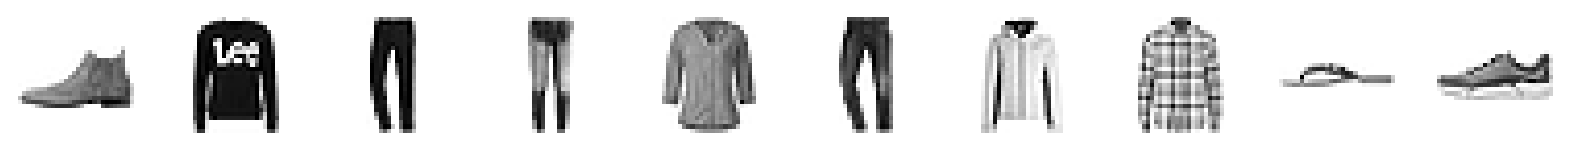

Variational Autoencode Reconstructions:


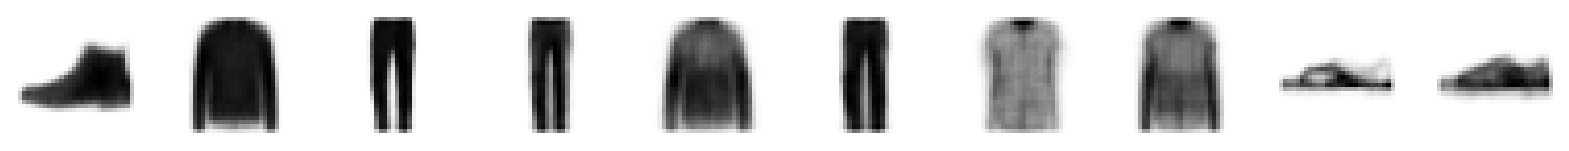

In [16]:
example_images = x_test[:1000]
example_labels = y_test[:1000]

z_mean, z_log_var, reconstructions = vae.predict(example_images)

print("Example images:")
display_images(example_images)
print("Variational Autoencode Reconstructions:")
display_images(reconstructions)

### Visualized Embedding in the latent space

In [17]:
# Encode example images
z_mean, z_var, z = encoder.predict(example_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [18]:
# Check out sample embeddings
print(z[:5])

[[ 1.8196563   0.17161016]
 [-0.03384637 -1.1850785 ]
 [-2.657215   -0.0280322 ]
 [-2.20924     1.1245457 ]
 [ 0.0397178  -0.05396417]]


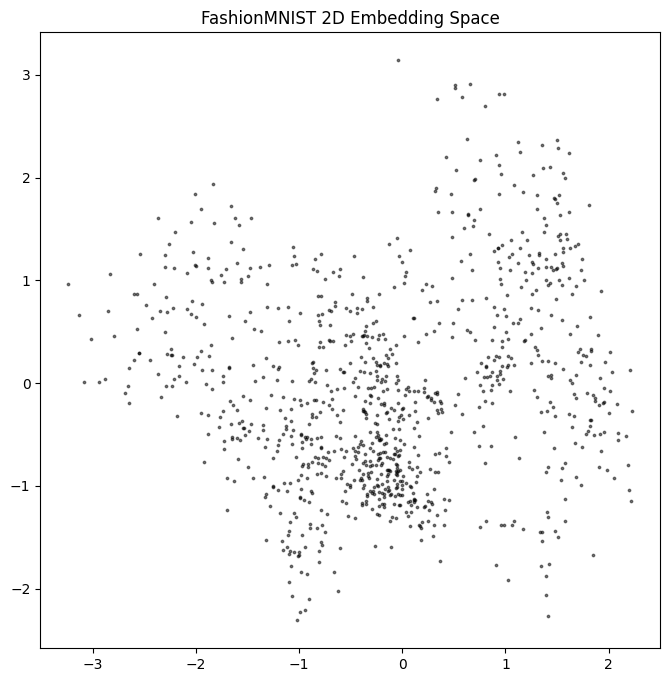

In [19]:
# Visualize Embeddings in 2D space
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.title("FashionMNIST 2D Embedding Space")
plt.show()

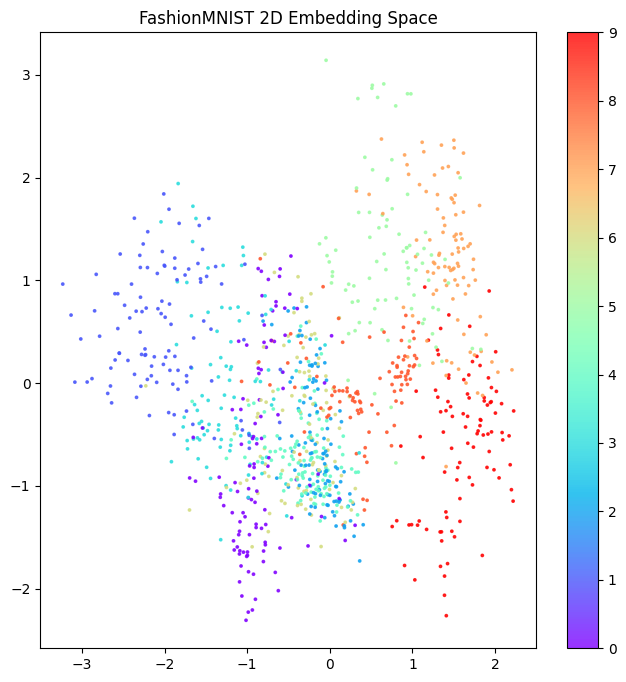

In [20]:
# Color embeddings by class
example_labels = y_test[:1000]

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.title("FashionMNIST 2D Embedding Space")
plt.colorbar()
plt.show()

### Generate new images with Decoder

In [23]:
# Generate sample points in the embedding (latent) space
grid_width, grid_height = (6, 3)
sample = np.random.normal(size=(grid_width * grid_height, 2))

In [24]:
# Decode sample points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Show points in Embedding space and the corresponding generated images

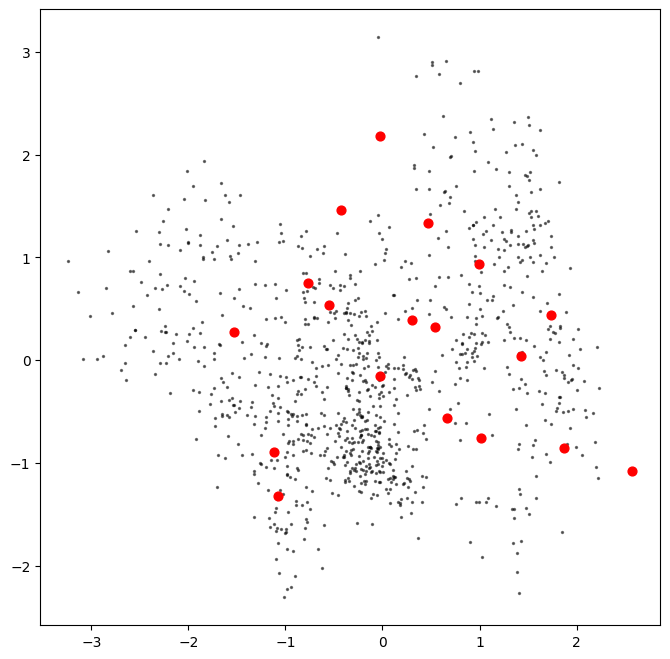

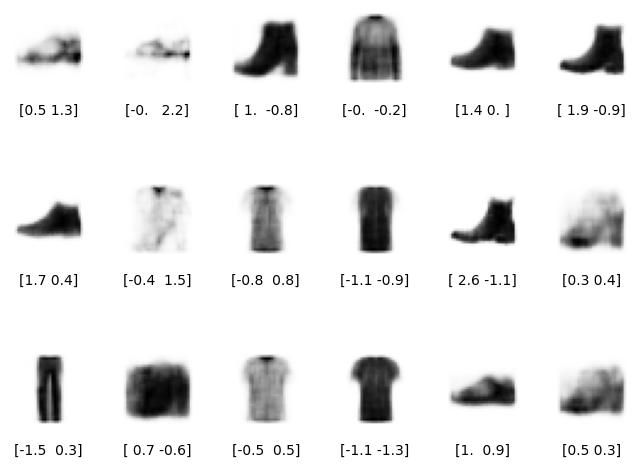

In [25]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(sample)

plt.figure(figsize=(8, 8))

# Original embeddings
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# New Sample point
plt.scatter(sample[:, 0], sample[:, 1], c="red", alpha=1, s=40)
plt.show()

# Show generated images
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap="Greys")